In [1]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import pathlib

In [2]:
PATH_KVASIR = 'E:\\Gastroscopies\\hyper_kvasir\\upper-gi-tract\\anatomical-landmarks'
batch_size = 32
img_height = 400
img_width = 400

In [3]:
# load pre-trained (imagenet) DenseNet model : 121 which has [6,12,24,16] layers in the 4 dense blocks
DenseNet121 = tf.keras.applications.densenet.DenseNet121(include_top=False, weights='imagenet', input_shape =(img_height, img_width, 3))

In [4]:
# tf.keras.utils.plot_model(DenseNet121, to_file='DenseNet121.png', show_shapes=True, show_layer_names=True)

In [5]:
kvasir_dir = pathlib.Path(PATH_KVASIR)

train_ds = tf.keras.utils.image_dataset_from_directory(
    kvasir_dir,
    validation_split=0.1,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    kvasir_dir,
    validation_split=0.1,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

labels = train_ds.class_names
print(labels)

Found 2695 files belonging to 3 classes.
Using 2426 files for training.
Found 2695 files belonging to 3 classes.
Using 269 files for validation.
['pylorus', 'retroflex-stomach', 'z-line']


In [6]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomFlip('vertical')
    #tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [7]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(img_height, img_width),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
])

In [8]:
dense_end = tf.keras.Sequential([
    # https://www.pluralsight.com/guides/introduction-to-densenet-with-tensorflow
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1024,activation="relu"),
    tf.keras.layers.Dense(512,activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5)
])

prediction_layer = tf.keras.layers.Dense(3,activation='softmax')

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [10]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = resize_and_rescale(x)
x = DenseNet121(x)
x = dense_end(x, training = True)
outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

# initially freeze DenseNet to avoid overfitting, will unfreeze during fine-tuning 
for layer in model.layers[:-2]:
    layer.trainable=False 
    
for layer in model.layers[-2:]:
    layer.trainable=True

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00002),
    metrics=['accuracy']
)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 400, 400, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 400, 400, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 400, 400, 3)       0         
_________________________________________________________________
densenet121 (Functional)     (None, 12, 12, 1024)      7037504   
_________________________________________________________________
sequential_2 (Sequential)    (None, 512)               1580544   
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 1539      
Total params: 8,619,587
Trainable params: 1,579,011
Non-trainable params: 7,040,576
___________________________________________

In [ ]:
### TEST UNTRAINED MODEL ###
import matplotlib.pyplot as plt

image_batch, label_batch = next(iter(train_ds))
pred = model.predict(image_batch)

source = image_batch[0].numpy()/255
index_pred = np.argmax(pred[0])
index_real = label_batch[0]

plt.imshow(source)
plt.title("pred-> " + labels[index_pred]+" | real->" + labels[index_real])
plt.axis("off")

(-0.5, 399.5, 399.5, -0.5)

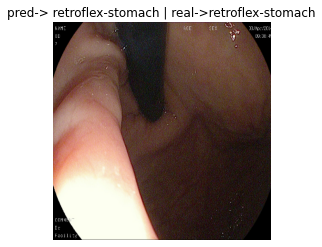

In [11]:
model.fit(
    train_ds,
    epochs=1,
    validation_data=train_ds
)

model.save('model.h5')

In [ ]:
model.fit(
    train_ds,
    epochs=1,
    validation_data=train_ds
)

model.save('model.h5')